# RAILS — Railbed Analysis & Image Learning System

"RAILS“ ist ein fiktiver Projektname und steht in keiner Verbindung zu bestehenden Produkten, Marken oder Organisationen, etwaige Namensähnlichkeiten sind zufällig und nicht beabsichtigt.

Dieses Notebook behandelt die Analyse und das Clustering von Schienenuntergrund-Bilddaten im Rahmen des Master Moduls *„Maschinelles Lernen“*. Grundlage sind rund 50.000 Graustufenbilder aus Messfahrten mehrerer europäischer Städte, die verschiedene Oberbautypen wie Schotter, Asphalt oder Rasen zeigen.  
 
Ziel ist es, mit Hilfe von **Clustering- und Klassifikationsverfahren** Muster und Strukturen in den Daten zu erkennen und die Leistungsfähigkeit unterschiedlicher Ansätze zu vergleichen. Dazu werden die Bilder vorverarbeitet, mithilfe eines vortrainierten CNN in Embeddings überführt und anschließend mit KMeans gruppiert.
 
Das Notebook ist so strukturiert, dass es den gesamten Workflow von der technischen Vorbereitung bis zur Auswertung abbildet:  
- Zunächst erfolgt das **Setup** der Umgebung sowie die **Konfiguration** der Pfade und Parameter.  
- Anschließend werden **Datensatzstruktur und Metadaten** untersucht, bevor die **Feature-Extraktion** mit einem CNN durchgeführt wird.  
- Die resultierenden Features werden **normalisiert und mittels PCA reduziert**, um sie für Clustering-Algorithmen vorzubereiten.  
- Im Kernteil wird **KMeans** angewendet, systematisch evaluiert und visuell dargestellt.  
- Schließlich werden die **Cluster-Ergebnisse gespeichert**, Reports erzeugt und eine detaillierte **Tenant-Analyse** erstellt.  
 
Im Fokus steht die praktische Anwendung moderner Machine-Learning-Techniken auf reale Daten sowie eine transparente Dokumentation der Ergebnisse mit Metriken und Visualisierungen

# Inhaltsverzeichnis
- [Einleitung](#rails--railbed-analysis--image-learning-system)
- [1. Setup: Importe & Umgebung](#1-setup-importe--umgebung)
- [2. Konfiguration: Pfade, Modellparameter](#2-konfiguration-pfade-modellparameter)
- [3. Ergebnisse-Verzeichnis & Datensatz-Check](#3-ergebnisse-verzeichnis--datensatz-check)
- [4. Dateiname-Parsing, Dataset-Metadaten & Tenant-Verteilung](#4-dateiname-parsing-dataset-metadaten--tenant-verteilung)
- [5. Feature-Extraktion](#5-feature-extraktion)
- [5.1 Feature-Extraktion vorbereiten: Funktionen & Pipeline](#51-feature-extraktion-vorbereiten-funktionen--pipeline)
- [5.2 Feature-Extraktion ausführen (Timing & Valid-Filter)](#52-feature-extraktion-ausführen-timing--valid-filter)
- [6. Feature-Nachbearbeitung (Normalisierung & PCA → Vorbereitung fürs Clustering)](#6-feature-nachbearbeitung-normalisierung--pca--vorbereitung-fürs-clustering)
- [7. K-Means](#7-k-means)
- [7.1 K-Means & Clusteranalyse](#71-k-means--clusteranalyse)
- [7.2 K-Means-Clusterbeispiele: Visualisierung von Beispielbildern](#72-k-means-clusterbeispiele-visualisierung-von-beispielbildern)
- [8. Visualisierung: K-Means mit t-SNE](#8-visualisierung-k-means-mit-t-sne)
- [9. Cluster-Ergebnisse speichern](#9-cluster-ergebnisse-speichern)
- [9.1 Speicher-Helfer definieren (Ordner/Bildkopie/Metadaten)](#91-speicher-helfer-definieren-ordnerbildkopiemetadaten)
- [9.2 K-Means-Cluster speichern (Ausführung)](#92-k-means-cluster-speichern-ausführung)
- [10. Tenant-Cluster-Analyse (Heatmap & Detailstatistik)](#10-tenant-cluster-analyse-heatmap--detailstatistik)
- [11. Clustering-Report (JSON) erstellen & Kernergebnisse ausgeben](#11-clustering-report-json-erstellen--kernergebnisse-ausgeben)
- [12. Ergebnisse der Clustering Phase](#12-ergebnisse-der-clustering-phase)

## 1. Setup: Importe & Umgebung

**Was:**  
- Import zentraler Bibliotheken (Datenhandling, Visualisierung, ML/DL).  

**Warum:**  
- Konsistente, reproduzierbare Läufe und Zentralisierung.


In [32]:
# Import Required Libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import cv2
from collections import Counter, defaultdict
from PIL import Image

# Machine Learning Libraries
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, normalize

# Deep Learning Libraries - Import AFTER setting environment variables
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Image Processing
from img_preprocessing import ImagePreprocessor

# Visualization
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Konfiguration: Pfade, Modellparameter

**Was:**  
- Anlegen lauf-zeitgestempelter Ergebnisordner (`RESULTS_PATH`, `CLUSTERS_PATH`).  
- Definition zentraler Parameter für Feature-Extraktion und Clustering.  
- Ausgabe eines kompakten **Konfigurations-Snapshots** zur Nachvollziehbarkeit.

**Warum:**  
- **`TIMESTAMP`**: Versioniert jeden Run → kein Überschreiben, einfache Nachverfolgung & Vergleichbarkeit.  
- **`DATASET_PATH="./datasets/clustering_sample_10000"`**: Arbeitsdatensatz; kann später skaliert werden.  
- **`BASE_RESULTS_PATH` / `RESULTS_PATH` / `CLUSTERS_PATH`**: Saubere Trennung von Analyseartefakten und exportierten Clusterbildern.  
- **`BATCH_SIZE=32`**: Batchgröße **für die Feature-Extraktion** (unabhängig von MiniBatchKMeans).  
- **`IMG_SIZE=(224, 224)`**: Passendes Eingabeformat für ResNet50 (ImageNet).  
- **`FEATURE_DIM=1024`**: Resultiert aus **ResNet50 `conv4_block6_out` + GlobalAveragePooling**.  
- **`PCA_COMPONENTS=50`**: Dimensionsreduktion (schnelleres, stabileres Clustering).  
- **`RANDOM_STATE=42`**: Reproduzierbarkeit für PCA/t-SNE/K-Means.  
- **`N_CLUSTERS_RANGE=range(3, 16)`**: Historischer Rest aus der Explorationsphase; **in der Endfassung nicht genutzt**.

**Finale Parameter (gesetzt aus der Voranalyse):**  
- **K-Means:** `k={BEST_K}`, `n_init={BEST_INIT}`, `random_state={RANDOM_STATE}`.    
- **Feature Extractor:** `ResNet50 (conv4_block6_out)`  
- **Preprocessing:** `L2 normalization + PCA`


In [33]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Analysis timestamp: {TIMESTAMP}")
DATASET_PATH = "./datasets/clustering_sample_10000"
BASE_RESULTS_PATH = f"./results_{TIMESTAMP}"
RESULTS_PATH = f"{BASE_RESULTS_PATH}/clustering_analysis"
CLUSTERS_PATH = f"{BASE_RESULTS_PATH}/clustered_images"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
FEATURE_DIM = 1024 #Chosen because of ResNet50 layer conv4_block6_out
N_CLUSTERS_RANGE = range(3, 16)
PCA_COMPONENTS = 50
RANDOM_STATE = 42

# Finalized clustering parameters (optimized through experimental phase)
BEST_K = 5  # K-Means: highest silhouette score
BEST_INIT = 20 # K-Means: number of initializations to avoid local minima

# Finalized Feature Extraction Model
FEATURE_EXTRACTOR = 'ResNet50 (conv4_block6_out)'

#Finalized Preprocessing
PREPROCESSING = 'L2 normalization + PCA'

# Configuration snapshot
config_snapshot = {
    'timestamp': TIMESTAMP,
    'dataset_path': DATASET_PATH,
    'feature_extractor': 'ResNet50 (conv4_block6_out)',
    'preprocessing': 'L2 normalization + PCA',
    'pca_components': PCA_COMPONENTS,
    'kmeans_k': BEST_K,
    'dbscan_eps': BEST_EPS,
    'dbscan_min_samples': BEST_MIN_SAMPLES,
    'random_state': RANDOM_STATE
}

print(f"Run timestamp: {TIMESTAMP}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Clustered images will be saved to: {CLUSTERS_PATH}")
print("\nFinalized parameters:")
for key, value in config_snapshot.items():
    if key != 'timestamp':
        print(f"  {key}: {value}")

print(f"Results will be saved to:")
print(f"  Analysis results: {RESULTS_PATH}")
print(f"  Clustered images: {CLUSTERS_PATH}")


Analysis timestamp: 20250907_151404
Run timestamp: 20250907_151404
Results will be saved to: ./results_20250907_151404/clustering_analysis
Clustered images will be saved to: ./results_20250907_151404/clustered_images

Finalized parameters:
  dataset_path: ./datasets/clustering_sample_10000
  feature_extractor: ResNet50 (conv4_block6_out)
  preprocessing: L2 normalization + PCA
  pca_components: 50
  kmeans_k: 5
  dbscan_eps: 0.25
  dbscan_min_samples: 5
  random_state: 42
Results will be saved to:
  Analysis results: ./results_20250907_151404/clustering_analysis
  Clustered images: ./results_20250907_151404/clustered_images


## 3. Ergebnisse-Verzeichnis & Datensatz-Check

**Was:**  
- Anlage laufzeitgestempelter Ergebnisordner (Analyse, Clusterbilder), Ausgabe der Pfade.  
- Sanity-Check des Datensatzpfads; Fallback: Auflistung vorhandener Datasets mit Bildanzahl.
- Zählen aller `.png`-Dateien im gewählten Dataset.  
- Persistieren einer `run_metadata.json` (Pfad- und Konfig-Snapshot).

**Warum:**  
- **Ordnererstellung** verhindert Fehler bei wiederholten Läufen.  
- **Pfad-/Existenz-Check** reduziert Fehlersuche bei falschen Datasetangaben.  
- **Bildzählung** schafft Transparenz (Basis für spätere Prozentangaben, Laufzeitabschätzungen).  
- **`run_metadata.json`** dokumentiert Pfade & Konfiguration (Reproduzierbarkeit, Vergleichbarkeit zwischen Runs).

**Outputs:**  
- Verzeichnisse: `RESULTS_PATH`, `CLUSTERS_PATH`  
- Datei: `RESULTS_PATH/run_metadata.json`  
- Konsolen-Logs mit Pfaden und Bildanzahl


In [34]:
# Create timestamped result roots (idempotent: no error if folders already exist)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
Path(CLUSTERS_PATH).mkdir(parents=True, exist_ok=True)

print(f"Created timestamped directories:")
print(f"Dataset path: {DATASET_PATH}")
print(f"Analysis results path: {RESULTS_PATH}")
print(f"Clustered images path: {CLUSTERS_PATH}")

# Check dataset existence; if missing, enumerate available subfolders under ./datasets
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path {DATASET_PATH} does not exist!")
    print("Available dataset directories:")
    datasets_dir = Path("./datasets")
    if datasets_dir.exists():
        for subdir in datasets_dir.iterdir():
            if subdir.is_dir():
                # Count only files ending with '.png' (case-sensitive)
                img_count = len([f for f in subdir.iterdir() if f.suffix == '.png'])
                print(f"  {subdir.name}: {img_count} images")
else:
    # Count .png files in the selected dataset (flat folder expected)
    img_count = len([f for f in Path(DATASET_PATH).iterdir() if f.suffix == '.png'])
    print(f"Found {img_count} images in dataset")

# Build a metadata snapshot for this run (paths, counts, and core configuration)
run_metadata = {
    'timestamp': TIMESTAMP,  # run identifier
    'dataset_path': str(Path(DATASET_PATH).resolve()),
    'total_images_found': img_count if os.path.exists(DATASET_PATH) else 0,
    'analysis_results_path': str(Path(RESULTS_PATH).resolve()),
    'clustered_images_path': str(Path(CLUSTERS_PATH).resolve()),
    'configuration': {
        'batch_size': BATCH_SIZE,
        'img_size': IMG_SIZE,
        'feature_dim': FEATURE_DIM,
        'n_clusters_range': list(N_CLUSTERS_RANGE),
        'pca_components': PCA_COMPONENTS,
        'random_state': RANDOM_STATE
    }
}

# Persist metadata to JSON for reproducibility/audit
with open(f"{RESULTS_PATH}/run_metadata.json", 'w') as f:
    json.dump(run_metadata, f, indent=2)
    
print(f"\nRun metadata saved to: {RESULTS_PATH}/run_metadata.json")


Created timestamped directories:
Dataset path: ./datasets/clustering_sample_10000
Analysis results path: ./results_20250907_151404/clustering_analysis
Clustered images path: ./results_20250907_151404/clustered_images
Found 10000 images in dataset

Run metadata saved to: ./results_20250907_151404/clustering_analysis/run_metadata.json


## 4. Dateiname-Parsing, Dataset-Metadaten & Tenant-Verteilung

**Was:**  
- Parsen der Dateinamen mit Suffix `_C.png`, um **tenant**, **SID** und **original_filename** zu extrahieren.  
- Einlesen des Datasets zu einer **Dateiliste** und Aggregation der **Tenant-Verteilung**.
- Ausgabe von **Gesamtzahl**, **#Tenants** und **Prozentanteilen** je Tenant.

**Warum:**  
- Die Metadaten aus dem Dateinamen erlauben **Slicing** (z. B. Auswertung pro Tenant) und **Qualitätskontrollen** (Ungleichgewichte erkennen).  
- Die Fokussierung auf `_C.png` stellt sicher, dass nur **konforme, bereinigte** Bildvarianten verarbeitet werden (einheitliche Pipeline).

**Outputs:**  
- `image_files` (Liste mit Pfad + extrahierten Metadaten)  
- `tenant_distribution` (Dict mit Zählungen)  
- Konsolen-Logs (Totals, #Tenants, Verteilung in %)


In [35]:
def parse_filename(filename: str):
    """Parse filename to extract tenant, SID, and original filename."""
    # Expect filenames ending with '_C.png' (case-sensitive)
    # Pattern convention: {tenant}_{sid}_{original}_C.png
    if not filename.endswith('_C.png'):
        return None, None, None
    
    name_without_ext = filename[:-6]  # Remove '_C.png' (6 characters)
    parts = name_without_ext.split('_')
    
    # Require at least 3 parts: tenant, sid, and the remaining original name
    if len(parts) >= 3:
        tenant = parts[0]
        sid = parts[1]
        original_filename = '_'.join(parts[2:])
        return tenant, sid, original_filename
    
    # Fallback if naming does not match the expected convention
    return None, None, None

def load_dataset_info(dataset_path: str):
    """Load and analyze dataset information."""
    # Build file index and aggregate tenant counts based on parsed filenames
    image_files = []
    tenant_distribution = defaultdict(int)
    
    # Non-recursive, case-sensitive pattern: only matches '*_C.png' in the given folder
    for file_path in Path(dataset_path).glob('*_C.png'):
        filename = file_path.name
        tenant, sid, original_name = parse_filename(filename)
        
        # Keep only files that match the naming convention
        if tenant:
            image_files.append({
                'filepath': str(file_path),
                'filename': filename,
                'tenant': tenant,
                'sid': sid,
                'original_name': original_name
            })
            tenant_distribution[tenant] += 1
    
    return image_files, dict(tenant_distribution)

# Load dataset information (flat folder expected)
print("Loading dataset information...")
image_files, tenant_distribution = load_dataset_info(DATASET_PATH)

# Summary (assumes >=1 valid image; add guard if needed)
print(f"\nTotal images: {len(image_files)}")
print(f"Number of tenants: {len(tenant_distribution)}")
print("\nTenant distribution:")
for tenant, count in sorted(tenant_distribution.items()):
    percentage = (count / len(image_files)) * 100
    print(f"  {tenant}: {count} images ({percentage:.1f}%)")


Loading dataset information...

Total images: 10000
Number of tenants: 8

Tenant distribution:
  ava: 1250 images (12.5%)
  bernmobil: 1250 images (12.5%)
  bvb: 1250 images (12.5%)
  cts: 1250 images (12.5%)
  gent: 1250 images (12.5%)
  gvb: 1250 images (12.5%)
  retm: 1250 images (12.5%)
  vbz: 1250 images (12.5%)


### 5. Feature-Extraktion

### 5.1 Feature-Extraktion vorbereiten: Funktionen & Pipeline

**Was:**  
- Hilfsfunktionen zum Laden/Preprocessen einzelner Bilder, Aufbau des **ResNet50**-Encoders bis **`conv4_block6_out`** (mit **GlobalAveragePooling**) sowie **batchweises** Ableiten der Feature-Embeddings.  
- Rückgabe: Feature-Matrix **(N × 1024)** und Liste der erfolgreich verarbeiteten Pfade.

**Warum:**  
- Klare Trennung von **I/O**, **Modellkonstruktion** und **Batch-Inferenz** vereinfacht Debugging und ermöglicht späteren Encodertausch ohne Code-Duplikate.
- Feature-Extraktion: **ResNet50 `conv4_block6_out` + GlobalAveragePooling** → **1024-dimensionale** Vektoren (finale Basis für L2 + PCA). 

**Outputs:**  
- **Keine Dateien** – nur In-Memory: `features` (N×1024) und `valid_paths` für Folgeschritte (Normalisierung, PCA, Clustering).


In [36]:
def load_and_preprocess_image(image_path: str, target_size: tuple = IMG_SIZE):
    """Load and preprocess image for ResNet50."""
    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        # insert preprocessing here
        # for exmaple:
        #img = ImagePreprocessor.method_3_gamma_correction(img)
        img_array = image.img_to_array(img)    
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None


def create_feature_extractor():
    """Create ResNet50 feature extractor up to 'conv4_block6_out' with GAP."""
    print("Loading ResNet50 model (conv4_block6_out + GAP)...")
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    x = base_model.get_layer('conv4_block6_out').output
    x = GlobalAveragePooling2D(name='gap_conv4')(x)  # -> (None, 1024)
    model = Model(inputs=base_model.input, outputs=x, name='resnet50_conv4_gap')
    print(f"Feature extractor output shape: {model.output_shape}")
    return model


def extract_features_batch(model, image_paths: list, batch_size: int = BATCH_SIZE):
    """Extract features from images in batches."""
    features = []
    valid_paths = []
    
    print(f"Extracting features from {len(image_paths)} images...")
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_valid_paths = []
        
        # Load batch images
        for img_path in batch_paths:
            img_array = load_and_preprocess_image(img_path)
            if img_array is not None:
                batch_images.append(img_array[0])  # Remove batch dimension
                batch_valid_paths.append(img_path)
        
        if batch_images:
            # Convert to numpy array and predict
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)
            
            features.extend(batch_features)
            valid_paths.extend(batch_valid_paths)
        
        # Progress update
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {min(i + batch_size, len(image_paths))}/{len(image_paths)} images")
    
    return np.array(features), valid_paths


### 5.2 Feature-Extraktion ausführen (Timing & Valid-Filter)

**Was:**  
- Initialisieren des **ResNet50**-Feature-Extractors bis **`conv4_block6_out`** (mit GlobalAveragePooling), Sammeln der `image_paths` und **batchweise** Extraktion der Embeddings.  
- Messung der Laufzeit und Ausgabe zentraler Kennzahlen (Shape, Anzahl gültiger Bilder).  
- Filtern nicht ladbarer Bilder und Aktualisieren von `image_files` auf die valide Teilmenge.

**Warum:**  
- Die Laufzeitmessung unterstützt die Abschätzung von Skalierung und geeigneten Batchgrößen.  
- Der Valid-Filter stellt sicher, dass nachfolgende Schritte (Normalisierung, PCA, Clustering) nur konsistente Daten erhalten.


In [37]:
# Extract features using ResNet50
print("=" * 80)
print("FEATURE EXTRACTION")
print("=" * 80)

# Create feature extractor
feature_extractor = create_feature_extractor()  # builds ResNet50 backbone 

# Extract image paths
image_paths = [item['filepath'] for item in image_files]  # preserve order for alignment with features

# Extract features
start_time = time.time()
features, valid_paths = extract_features_batch(feature_extractor, image_paths)  # batched inference
extraction_time = time.time() - start_time

print(f"\nFeature extraction completed in {extraction_time:.2f} seconds")
print(f"Extracted features shape: {features.shape}")  # expect (N_valid, 1024)
print(f"Valid images: {len(valid_paths)}/{len(image_paths)}")

# Update image_files to only include valid images
valid_image_files = []
for img_file in image_files:
    if img_file['filepath'] in valid_paths:  # keep only successfully processed paths
        valid_image_files.append(img_file)

image_files = valid_image_files  # downstream steps use the filtered metadata list
print(f"Updated image files: {len(image_files)}")


FEATURE EXTRACTION
Loading ResNet50 model (conv4_block6_out + GAP)...
Feature extractor output shape: (None, 1024)
Extracting features from 10000 images...
  Processed 320/10000 images
  Processed 640/10000 images
  Processed 960/10000 images
  Processed 1280/10000 images
  Processed 1600/10000 images
  Processed 1920/10000 images
  Processed 2240/10000 images
  Processed 2560/10000 images
  Processed 2880/10000 images
  Processed 3200/10000 images
  Processed 3520/10000 images
  Processed 3840/10000 images
  Processed 4160/10000 images
  Processed 4480/10000 images
  Processed 4800/10000 images
  Processed 5120/10000 images
  Processed 5440/10000 images
  Processed 5760/10000 images
  Processed 6080/10000 images
  Processed 6400/10000 images
  Processed 6720/10000 images
  Processed 7040/10000 images
  Processed 7360/10000 images
  Processed 7680/10000 images
  Processed 8000/10000 images
  Processed 8320/10000 images
  Processed 8640/10000 images
  Processed 8960/10000 images
  Proce

## 6. Feature-Nachbearbeitung (Normalisierung & PCA → Vorbereitung fürs Clustering)

**Was:**  
- L2-Normierung der Embeddings (zeilenweise) und optionale PCA-Reduktion auf `PCA_COMPONENTS`.  
- Ausgeben von Kennzahlen vor/nach Normalisierung sowie erklärter Gesamtvarianz der PCA.

**Warum:**  
- L2-Normierung macht Distanzen vergleichbar und stabilisiert Metriken.  
- PCA reduziert Dimensionen, Rauschen und Rechenzeit.

**Besonderheiten:**  
- PCA-Fit erfolgt auf **normalisierten** Features; `random_state` für Reproduzierbarkeit gesetzt.  
- Default für das Clustering sind die **voll normalisierten** Features. PCA-Features optional testen/umschalten.

**Outputs:**  
- `features_normalized`, `features_pca`
- Konsolen-Stats (vor/nach Normalisierung, PCA-Varianz, Shapes)


In [38]:
# Normalize features to unit length per sample (stabilizes distances for K-Means/DBSCAN)
print("Normalizing features...")
features_normalized = normalize(features, norm='l2', axis=1)

# Basic sanity statistics before/after normalization
print(f"Original feature statistics:")
print(f"  Mean: {features.mean():.4f}")
print(f"  Std: {features.std():.4f}")
print(f"  Min: {features.min():.4f}")
print(f"  Max: {features.max():.4f}")

print(f"\nNormalized feature statistics:")
print(f"  Mean: {features_normalized.mean():.4f}")
print(f"  Std: {features_normalized.std():.4f}")
print(f"  L2 norm (first sample): {np.linalg.norm(features_normalized[0]):.4f}")

# Optional dimensionality reduction (denoising + speed-up for clustering/TSNE)
print(f"\nApplying PCA to reduce dimensions from {FEATURE_DIM} to {PCA_COMPONENTS}...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
features_pca = pca.fit_transform(features_normalized)

# Report explained variance (sum) and resulting shape
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PCA features shape: {features_pca.shape}")


Normalizing features...
Original feature statistics:
  Mean: 0.4460
  Std: 0.4378
  Min: 0.0000
  Max: 8.0131

Normalized feature statistics:
  Mean: 0.0225
  Std: 0.0217
  L2 norm (first sample): 1.0000

Applying PCA to reduce dimensions from 1024 to 50...
PCA explained variance ratio: 0.9525
PCA features shape: (10000, 50)


## 7. K-Means

**Hinweis (Disclaimer):** Dieses finale Notebook führt **keine** Modellvalidierung mehr durch. Der angegebene **Silhouette-Score** wird lediglich aus der final gewählten Konfiguration mitgegeben; die Validierung erfolgte **separat** (siehe Begleitdokument) und nutzte die Metriken **Silhouette-Score**, **Davies–Bouldin-Index** und **Calinski–Harabasz-Index**.

### 7.1 K-Means & Clusteranalyse

**Was:**  
- **MiniBatchKMeans** mit **festen Parametern** (`k={BEST_K}`, `n_init={BEST_INIT}`, `random_state={RANDOM_STATE}`) auf den **PCA-reduzierten** und **L2-normalisierten** Features.  
- Ableitung der **Clusterlabels** (`cluster_labels`) und Anreicherung von `image_files` um das Feld **`cluster`**.  
- Kompakte **Qualitätsmetriken**  
- Übersicht je Cluster inkl. **Tenant-Verteilung** (Anzahl & Prozent).

**Warum:**  
- Das finale K-Means-Modell liefert die **produktiven Labels** als Basis für Export, Visualisierung und Berichte.  
- Tenant-Verteilungen unterstützen die **Interpretation** von Clustern und das Erkennen möglicher **Imbalances/Bias**.

**Outputs:**  
- In-Memory: `cluster_labels`, angereichertes `image_files['cluster']`.  
- Konsole: *Inertia*, *Silhouette*, Clustergrößen und **Tenant-Rangfolge** pro Cluster.


In [39]:

print("=" * 80)
print("K-MEANS (FINAL)")
print("=" * 80)
print(f"Using finalized K-Means configuration: k={BEST_K}, n_init={BEST_INIT}, random_state={RANDOM_STATE}")

final_kmeans = MiniBatchKMeans(
    n_clusters=BEST_K,
    random_state=RANDOM_STATE,
    batch_size=100,
    n_init=BEST_INIT
)

cluster_labels = final_kmeans.fit_predict(features_pca)

# Evaluate clustering quality
kmeans_inertia = final_kmeans.inertia_
kmeans_silhouette = silhouette_score(features_pca, cluster_labels)
print(f"K-Means (k={BEST_K}) — Inertia: {kmeans_inertia:.2f}, Silhouette: {kmeans_silhouette:.4f}")

# Add cluster labels to image metadata
for i, img_file in enumerate(image_files):
    img_file['cluster'] = int(cluster_labels[i])

# Cluster composition (Counts per cluster + Tenant distribution)
print(f"\nCluster Analysis:")
cluster_stats = defaultdict(lambda: defaultdict(int))

for img_file in image_files:
    cluster = img_file['cluster']
    tenant = img_file['tenant']
    cluster_stats[cluster]['total'] += 1
    cluster_stats[cluster][tenant] += 1

# Readable report per cluster
for cluster_id in sorted(cluster_stats.keys()):
    stats = cluster_stats[cluster_id]
    total = stats['total']
    print(f"\nCluster {cluster_id}: {total} images")
    
    tenant_counts = {k: v for k, v in stats.items() if k != 'total'}
    for tenant, count in sorted(tenant_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total) * 100
        print(f"  {tenant}: {count} ({percentage:.1f}%)")


K-MEANS (FINAL)
Using finalized K-Means configuration: k=5, n_init=20, random_state=42
K-Means (k=5) — Inertia: 510.50, Silhouette: 0.4007

Cluster Analysis:

Cluster 0: 2789 images
  bvb: 1229 (44.1%)
  vbz: 638 (22.9%)
  ava: 578 (20.7%)
  gvb: 172 (6.2%)
  retm: 171 (6.1%)
  cts: 1 (0.0%)

Cluster 1: 956 images
  cts: 536 (56.1%)
  gent: 252 (26.4%)
  bernmobil: 85 (8.9%)
  gvb: 60 (6.3%)
  vbz: 16 (1.7%)
  retm: 7 (0.7%)

Cluster 2: 1637 images
  cts: 517 (31.6%)
  gent: 462 (28.2%)
  gvb: 447 (27.3%)
  bernmobil: 94 (5.7%)
  vbz: 67 (4.1%)
  retm: 38 (2.3%)
  ava: 12 (0.7%)

Cluster 3: 1797 images
  retm: 1023 (56.9%)
  ava: 652 (36.3%)
  gvb: 29 (1.6%)
  bernmobil: 27 (1.5%)
  vbz: 26 (1.4%)
  gent: 24 (1.3%)
  cts: 16 (0.9%)

Cluster 4: 2821 images
  bernmobil: 1044 (37.0%)
  gvb: 542 (19.2%)
  gent: 512 (18.1%)
  vbz: 503 (17.8%)
  cts: 180 (6.4%)
  bvb: 21 (0.7%)
  retm: 11 (0.4%)
  ava: 8 (0.3%)


### 7.2 K-Means-Clusterbeispiele: Visualisierung von Beispielbildern

**Was:**  
- Zeigt pro Cluster eine Stichprobe zufälliger Bilder in einem Bildgrid (3 Spalten, mehrere Zeilen).  
- Nutzt die finalen K-Means-Labels (`image_files[i]['cluster']`) als Grundlage.

**Warum:**  
- Schnelle, visuelle Qualitätsprüfung der Clusterinhalte (Plausibilität, Ausreißer, Muster).

**Besonderheiten:**  
- Zufallsstichprobe ≠ „repräsentativste“ Beispiele. 
- Fehlerhafte oder fehlende Dateien werden textuell im Grid gekennzeichnet.  
- Ergebnisse werden als `cluster_<id>_examples.png` gespeichert.

**Outputs:**
- PNG-Bildtafeln je Cluster unter `RESULTS_PATH`, Konsolenlogs.


CLUSTER EXAMPLES


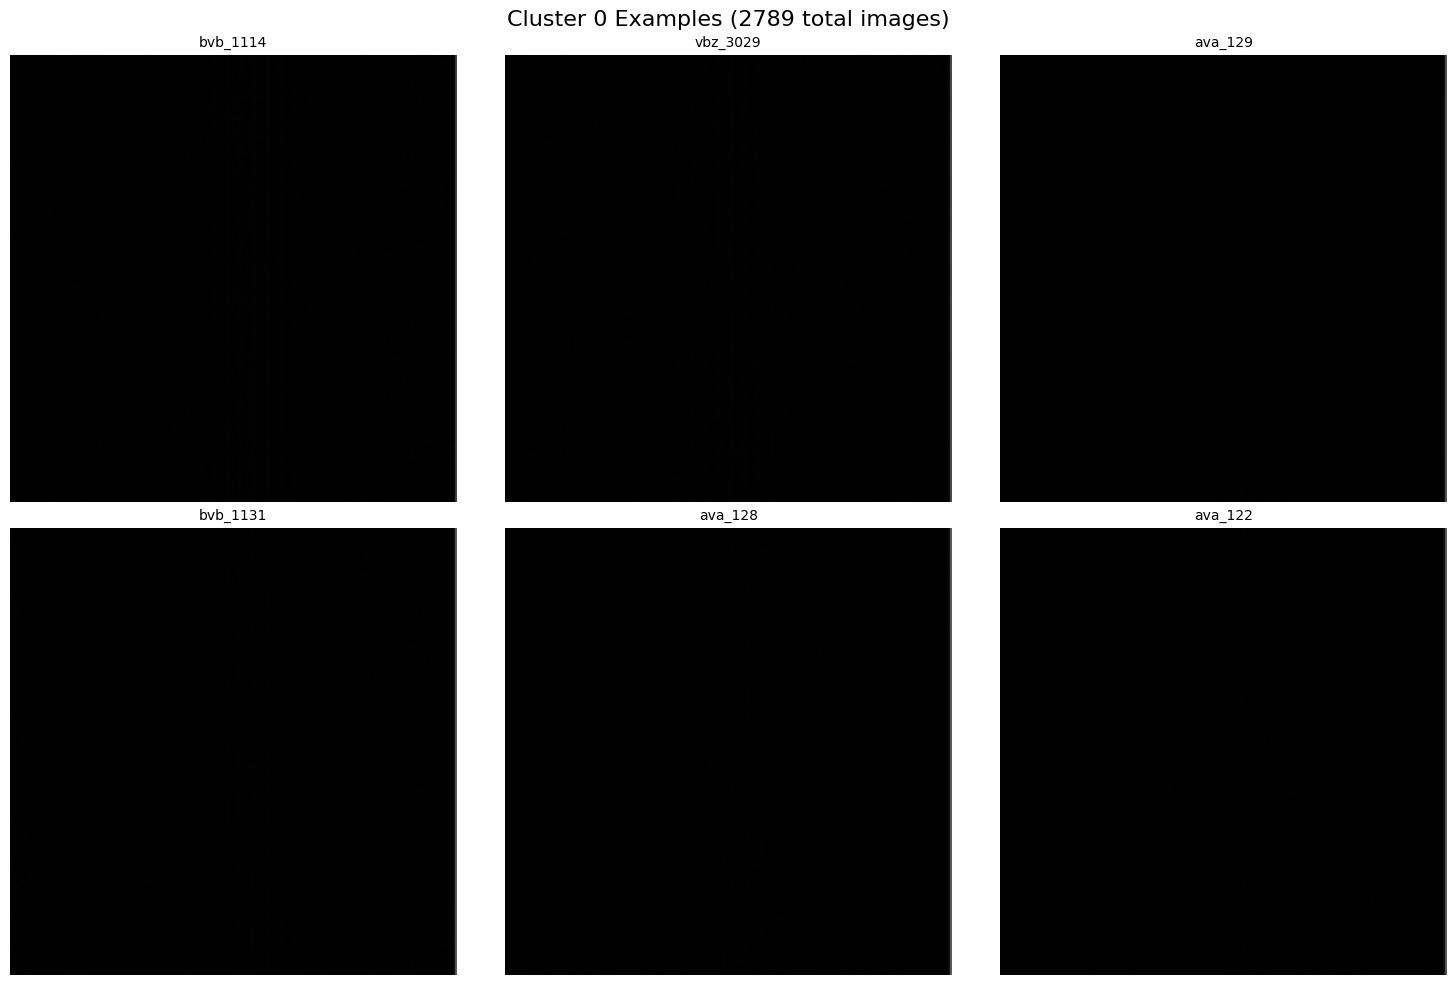

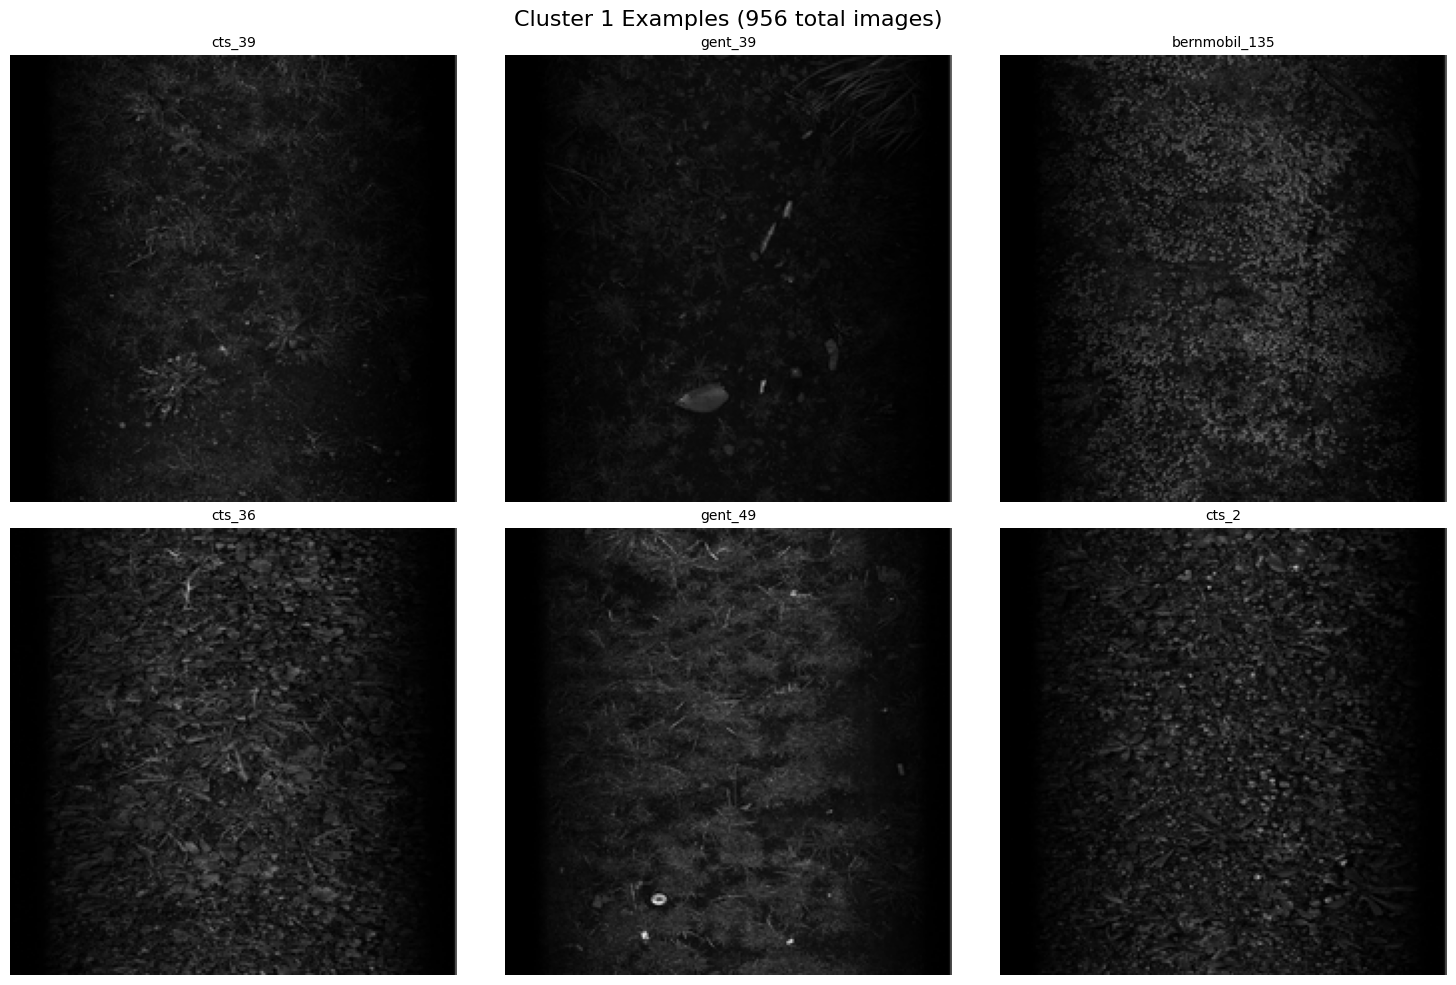

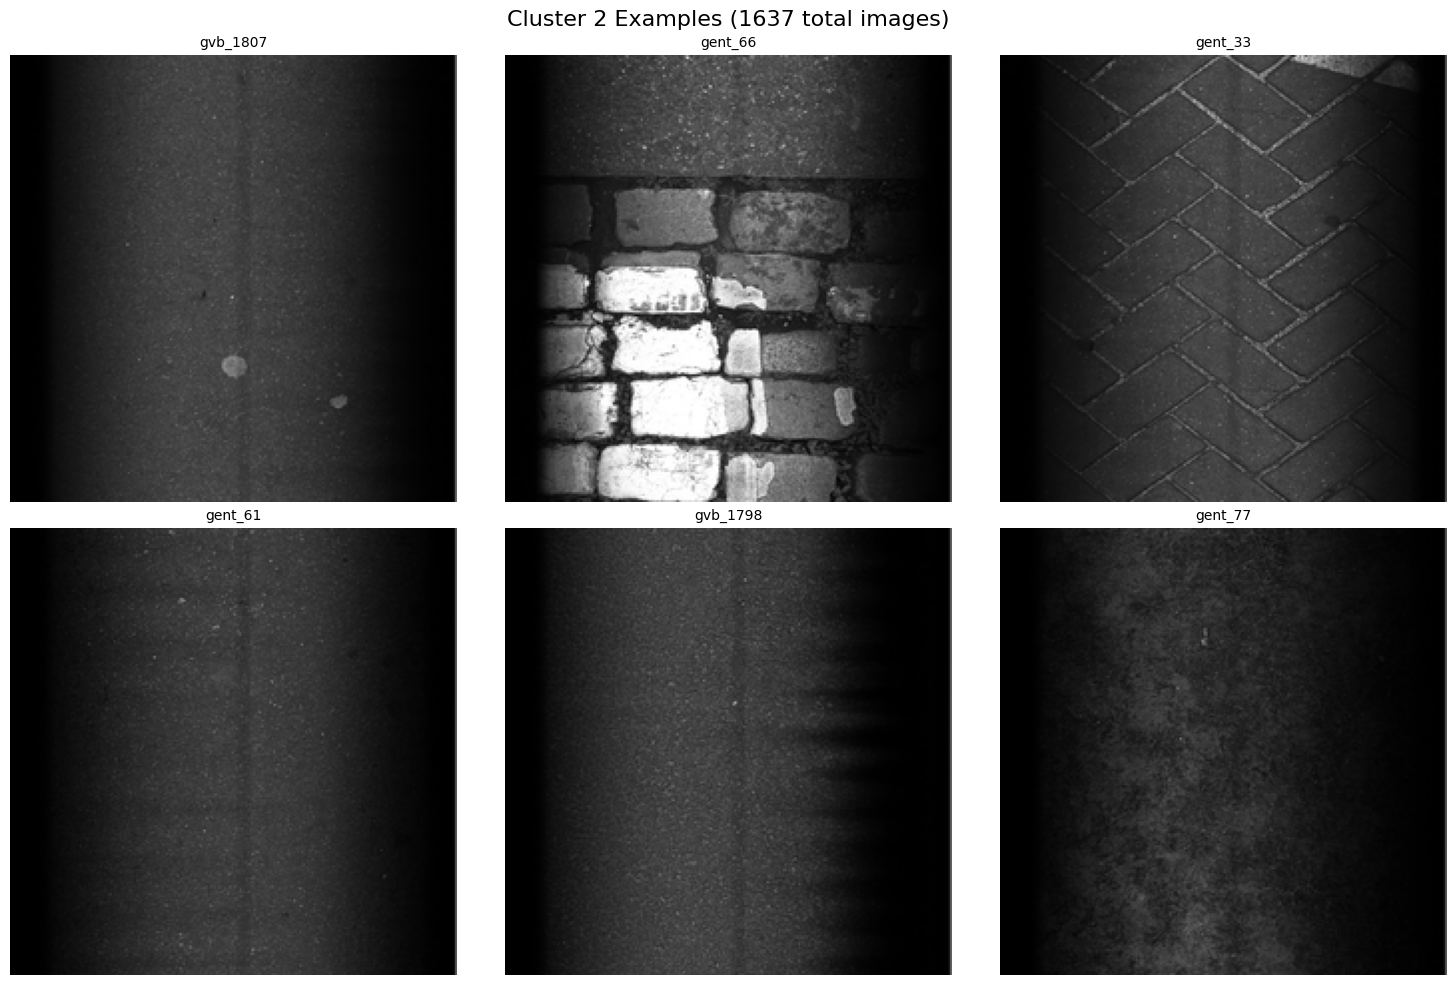

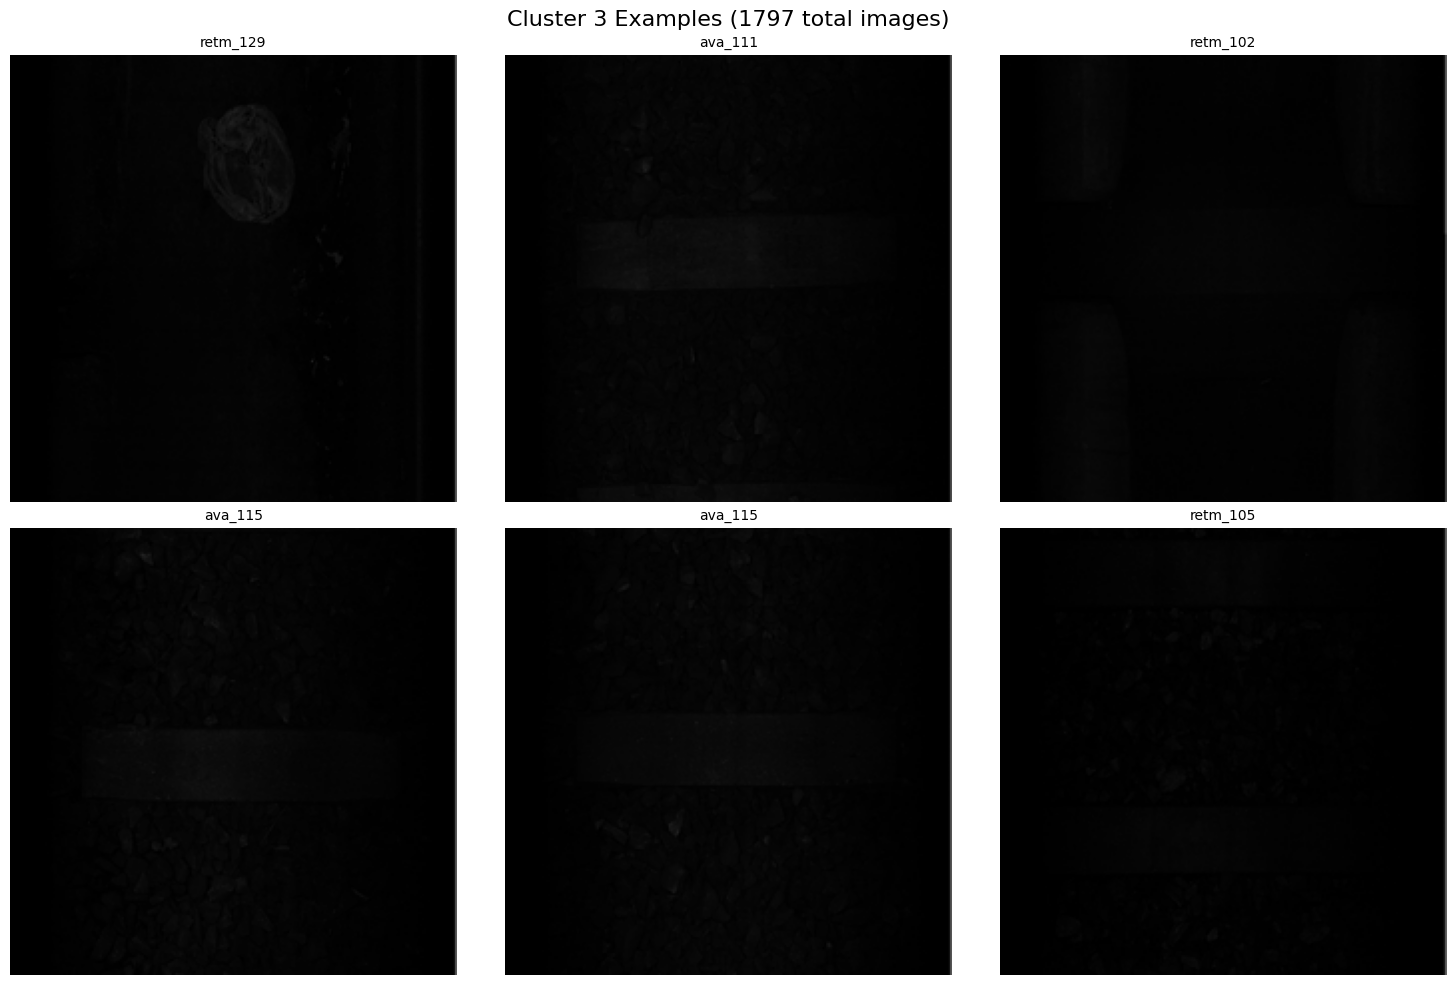

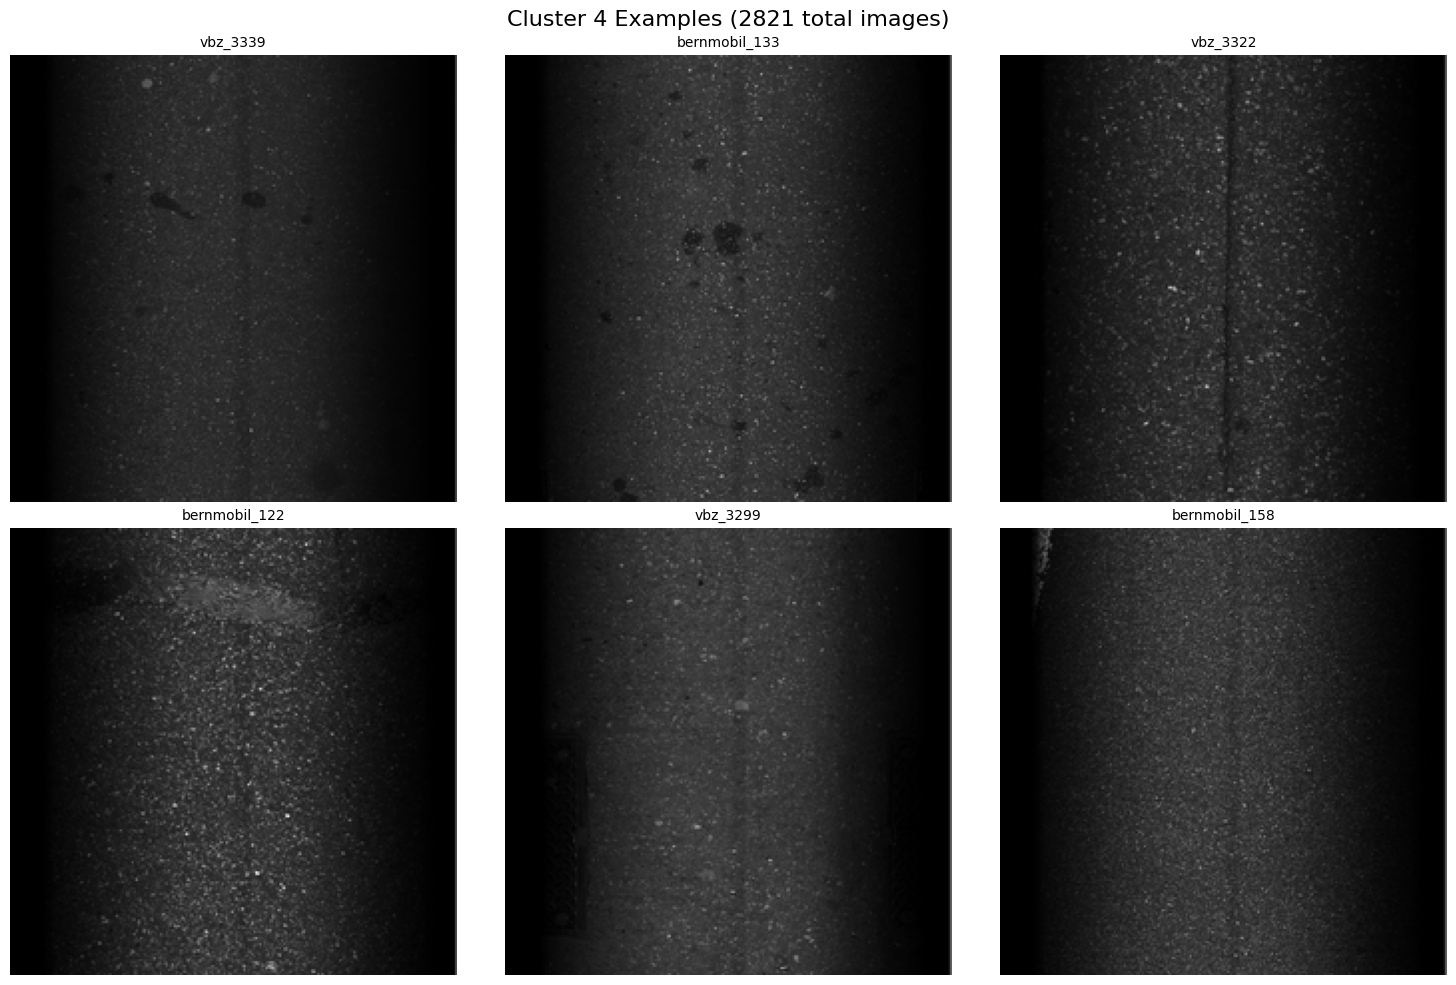

In [40]:
def display_cluster_examples(image_files, cluster_id, n_examples=6):
    """Display example images from a specific cluster."""
    # Collect all images that belong to the requested cluster
    cluster_images = [img for img in image_files if img['cluster'] == cluster_id]
    
    if not cluster_images:
        print(f"No images found for cluster {cluster_id}")
        return
    
    # Randomly sample examples (set np.random.seed(...) earlier for reproducibility)
    examples = np.random.choice(cluster_images, min(n_examples, len(cluster_images)), replace=False)
    
    # Create subplot grid (3 columns; rows computed from sample size)
    cols = 3
    rows = (len(examples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Cluster {cluster_id} Examples ({len(cluster_images)} total images)', fontsize=16)
    
    for i, img_info in enumerate(examples):
        row = i // cols
        col = i % cols
        
        # Load and display image; on failure, render a textual placeholder
        try:
            img = Image.open(img_info['filepath'])
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{img_info['tenant']}_{img_info['sid']}", fontsize=10)
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"Error loading\n{img_info['filename']}", 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide any empty subplot cells (if sample size not divisible by #cols)
    for i in range(len(examples), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    # Save a PNG panel per cluster to RESULTS_PATH
    plt.savefig(f"{RESULTS_PATH}/cluster_{cluster_id}_examples.png", dpi=300, bbox_inches='tight')
    plt.show()

# Render example grids for all discovered clusters ---
print("=" * 80)
print("CLUSTER EXAMPLES")
print("=" * 80)

for cluster_id in sorted(set(cluster_labels)):
    display_cluster_examples(image_files, cluster_id)


### 8. Visualisierung: K-Means mit t-SNE
 
**Was:**  
- berechnet ein 2D-t-SNE auf den PCA-Features (`features_pca`) mit stabilen Parametern (`init='pca'`, `learning_rate='auto'`, `dynamische Perplexity`)
- Erstellt eine zentrale Visualisierung der K-Means-Zuordnungen mit diskreten Farbkarten
- Verwendet `BoundaryNorm` für saubere Cluster-Trennung und eindeutige Legendenbeschriftung
 
**Warum:**  
- t-SNE wird genutzt, um die 50D-PCA-Features auf 2D zu reduzieren für eine intuitive Visualisierung der Cluster-Struktur
- stabile Parameter ermöglichen reproduzierbare Layouts für Vergleichbarkeit
- Fokus auf K-Means als finale Clustering-Methode
 
**Outputs:**  
- Zentrale t-SNE-Projektion der K-Means-Cluster
- Erstellung der Datei `clustering_tsne_visualization.png`

K-MEANS CLUSTER VISUALIZATION WITH t-SNE
Computing t-SNE embedding with stable parameters...
t-SNE completed with perplexity=50


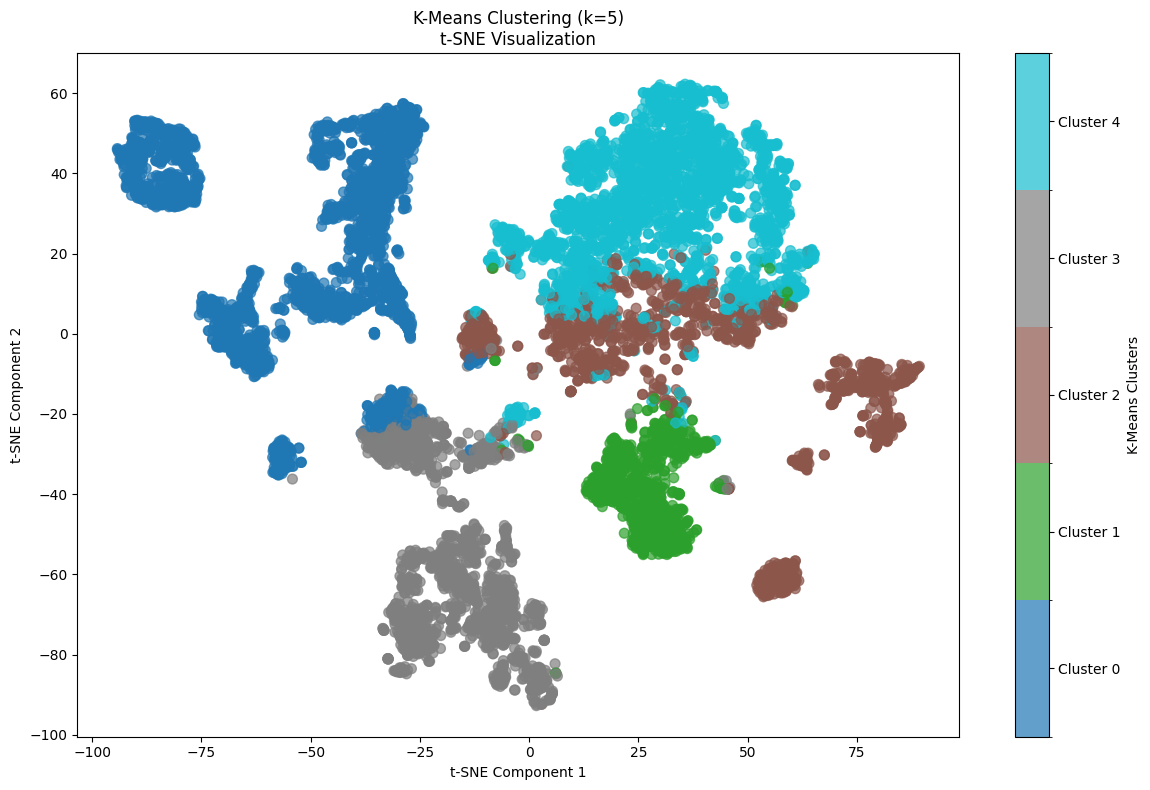

✓ K-Means clustering visualization saved as: ./results_20250907_151404/clustering_analysis/clustering_tsne_visualization.png


In [41]:
# Visualize K-Means clustering results with t-SNE
print("=" * 80)
print("K-MEANS CLUSTER VISUALIZATION WITH t-SNE")
print("=" * 80)

print("Computing t-SNE embedding with stable parameters...")
N = len(features_pca)
# Use stable t-SNE parameters for reproducible and better results
tsne = TSNE(
    n_components=2,
    init='pca',  # PCA initialization for better stability
    learning_rate='auto',  # Adaptive learning rate
    perplexity=min(50, max(5, int(N * 0.01))),  # Dynamic perplexity based on sample size
    max_iter=1500,  # More iterations for convergence
    random_state=RANDOM_STATE,
    metric='euclidean',
    early_exaggeration=12.0
)

tsne_features = tsne.fit_transform(features_pca)
print(f"t-SNE completed with perplexity={tsne.perplexity}")

# Create visualization with fixed discrete colors for K-Means
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# === K-MEANS PLOT WITH DISCRETE COLORS ===
# Remap K-Means labels to 0..C-1 for consistent coloring
unique_kmeans = sorted(set(cluster_labels))
kmeans_label_map = {old: new for new, old in enumerate(unique_kmeans)}
kmeans_colors = np.array([kmeans_label_map[label] for label in cluster_labels])

# Create discrete colormap for K-Means
n_kmeans_clusters = len(unique_kmeans)
kmeans_cmap = matplotlib.colors.ListedColormap(plt.cm.tab10(np.linspace(0, 1, n_kmeans_clusters)))
kmeans_norm = matplotlib.colors.BoundaryNorm(
    boundaries=np.arange(-0.5, n_kmeans_clusters, 1), 
    ncolors=n_kmeans_clusters
)

scatter = ax.scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=kmeans_colors,
    cmap=kmeans_cmap,
    norm=kmeans_norm,
    alpha=0.7,
    s=50
)
ax.set_title(f'K-Means Clustering (k={BEST_K})\nt-SNE Visualization')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

# Discrete colorbar for K-Means
cbar = plt.colorbar(scatter, ax=ax, ticks=range(n_kmeans_clusters))
cbar.set_ticklabels([f'Cluster {unique_kmeans[i]}' for i in range(n_kmeans_clusters)])
cbar.set_label('K-Means Clusters')

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/clustering_tsne_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ K-Means clustering visualization saved as: {RESULTS_PATH}/clustering_tsne_visualization.png")

### 9. Cluster-Ergebnisse speichern

#### 9.1 Speicher-Helfer definieren (Ordner/Bildkopie/Metadaten)
 
**Was:**  
- es werden drei Hilfsfunktionen für die Speicherung der Cluster-Ergebnisse definiert.
- `create_cluster_directories()`: Legt strukturierte Ordnerhierarchie an.
- `copy_images_to_clusters()`: Kopiert Originalbilder in ihre jeweiligen Cluster-Ordner mit Duplikatsvermeidung.
- `save_cluster_metadata()`: Erstellt detaillierte JSON-Metadaten pro Cluster mit Tenant-Statistiken und Bildlisten.
 
**Warum:**  
- Clustering-Ergebnisse werden dauerhaft und strukturiert gespeichert für spätere Analyse
- Bilder werden nach Clustern sortiert → vereinfacht manuelle Inspektion und Qualitätskontrolle der Clustering Verfahren
- JSON-File dokumentiert Cluster-Zusammensetzung, Tenant-Verteilung und verwendete Methodik
- Separierte Cluster ermöglichen gezielte Weiterverarbeitung einzelner Gruppen, hierdurch ist ein Labeln der Cluster einfach möglich, um eine spätere Klassifizierung von neuen Daten vornehmen zu können
 
**Besonderheiten:**  
- Ordner-Erstellung und Dateikopien überschreiben nicht bei identischen Dateien (Größenvergleich)
- Noise-Punkte (`-1`) werden speziell im noise/-Ordner gesammelt, reguläre Cluster in `cluster_<id>/`
 
**Outputs:**  
- Ordner mit kopierten Originalbildern im festgelegten Dateipfad: `{base_path}/{method_name}/cluster_<id>/`
- Metadaten Dateien je Cluster mit Angabe der `cluster_id`, `total_images`, `tenant_distribution` und den Details der Bilder
- Erstellung von Statistiken zur Anzahl der erfolgreichen Kopien, Anzahl der Fehler (wenn vorhanden) und die Größe der Cluster

In [42]:
def create_cluster_directories(base_path, method_name, cluster_labels, dbscan_labels=None):
    """Create directory structure for clustered images (K-Means).
    - Ensures Python int keys for cluster IDs (guards against numpy int types).
    """
    method_path = Path(base_path) / method_name
    method_path.mkdir(parents=True, exist_ok=True)

    # Input validation
    if method_name == 'dbscan' and dbscan_labels is None:
        raise ValueError("DBSCAN selected but 'dbscan_labels' is None.")
    if method_name not in ('kmeans', 'dbscan'):
        raise ValueError(f"Unknown method_name '{method_name}'. Use 'kmeans' or 'dbscan'.")

    # Collect unique cluster IDs and coerce to Python int
    if method_name == 'kmeans':
        labels = cluster_labels
    else:  # dbscan
        labels = dbscan_labels

    unique_clusters = sorted({int(c) for c in labels})
    if method_name == 'dbscan' and -1 in unique_clusters:
        # Put noise (-1) at the end
        unique_clusters = [c for c in unique_clusters if c != -1] + [-1]

    cluster_dirs = {}
    for cluster_id in unique_clusters:
        # Ensure folders exist; noise goes to a dedicated folder
        if cluster_id == -1:
            cluster_dir = method_path / 'noise'
        else:
            cluster_dir = method_path / f'cluster_{cluster_id}'
        cluster_dir.mkdir(parents=True, exist_ok=True)
        cluster_dirs[int(cluster_id)] = cluster_dir  # enforce Python int key

    return cluster_dirs


def copy_images_to_clusters(image_files, cluster_dirs, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Copy images into their respective cluster directories.
    - Validates inputs and label lengths.
    - Coerces cluster IDs to Python int for safe dict indexing.
    """
    print(f"\nCopying images to {method_name.upper()} cluster directories...")

    # Input validation
    if method_name == 'dbscan' and dbscan_labels is None:
        raise ValueError("DBSCAN selected but 'dbscan_labels' is None.")
    if method_name not in ('kmeans', 'dbscan'):
        raise ValueError(f"Unknown method_name '{method_name}'. Use 'kmeans' or 'dbscan'.")

    labels_to_use = cluster_labels if method_name == 'kmeans' else dbscan_labels
    if len(labels_to_use) != len(image_files):
        raise ValueError(
            f"Label count ({len(labels_to_use)}) does not match image_files count ({len(image_files)})."
        )

    copied_count = 0
    error_count = 0

    for i, img_file in enumerate(image_files):
        try:
            cluster_id = int(labels_to_use[i])  # enforce Python int
            source_path = Path(img_file['filepath'])
            target_dir = cluster_dirs.get(cluster_id)
            if target_dir is None:
                raise KeyError(f"No directory for cluster_id '{cluster_id}'. Did you call create_cluster_directories()?")

            target_path = target_dir / source_path.name

            # Copy only if missing or size differs
            if not target_path.exists() or target_path.stat().st_size != source_path.stat().st_size:
                shutil.copy2(source_path, target_path)
                copied_count += 1

        except Exception as e:
            print(f"Error copying {img_file.get('filename', source_path.name if 'source_path' in locals() else '<unknown>')}: {e}")
            error_count += 1

    print(f"Successfully copied {copied_count} images")
    if error_count > 0:
        print(f"Errors: {error_count}")

    return copied_count, error_count


def save_cluster_metadata(cluster_dirs, image_files, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Save per-cluster metadata (JSON) into each cluster directory.
    - Validates inputs and label lengths.
    - Ensures JSON-serializable cluster IDs and preserves non-ASCII characters.
    """
    print(f"\nSaving {method_name.upper()} cluster metadata...")

    # Input validation
    if method_name == 'dbscan' and dbscan_labels is None:
        raise ValueError("DBSCAN selected but 'dbscan_labels' is None.")
    if method_name not in ('kmeans', 'dbscan'):
        raise ValueError(f"Unknown method_name '{method_name}'. Use 'kmeans' or 'dbscan'.")

    labels_to_use = cluster_labels if method_name == 'kmeans' else dbscan_labels
    if len(labels_to_use) != len(image_files):
        raise ValueError(
            f"Label count ({len(labels_to_use)}) does not match image_files count ({len(image_files)})."
        )

    for cluster_id, cluster_dir in cluster_dirs.items():
        # Collect images for this cluster
        cluster_images = []
        for i, img_file in enumerate(image_files):
            if int(labels_to_use[i]) == int(cluster_id):
                cluster_images.append({
                    'filename': img_file['filename'],
                    'tenant': img_file['tenant'],
                    'sid': img_file['sid'],
                    'original_name': img_file['original_name']
                })

        # Basic stats
        tenant_counts = Counter(img['tenant'] for img in cluster_images)

        metadata = {
            'cluster_id': int(cluster_id),
            'method': method_name,
            'total_images': len(cluster_images),
            'tenant_distribution': dict(tenant_counts),
            'images': cluster_images
        }

        # Write JSON (preserve non-ASCII, pretty print)
        metadata_file = cluster_dir / 'cluster_metadata.json'
        with open(metadata_file, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)

    print(f"Metadata saved for {len(cluster_dirs)} clusters")


#### 9.2 K-Means-Cluster speichern (Ausführung)
 
**Was:**  
- Führt die K-Means-Cluster-Speicherung mit den in Abschnitt 10.1 definierten Hilfsfunktionen aus
- erstellt je gefundenem Cluster einen Ordner in der definierten Ordnerstruktur
- generiert die zuvor definierten Statistiken als JSON-Datei
 
**Warum:**  
- vereinfachte visuelle Kontrolle
- persistente Archivierung zur späteren Analyse
- gezielte Weiterverarbeitung
- direkte Vergleiche mit vorherigen Läufen durch Anlage der Ordnerstruktur inklusive Timestamp
 
**Besonderheiten:**  
- Zeitstempel-basierte Pfade für eindeutige Versionierung
- Ausgabe von detaillierten Statistiken und Fehler-Tracking
 
**Outputs:**  
- kopierte Originalbilder in der gewählten Ordnerstruktur `{CLUSTERS_PATH}/kmeans/cluster_<0..k-1>/`
- Metadaten Datei `cluster_metadata.json` für jedes Cluster
- Anzeige der Anzahl erstellter Ordner, Cluster-Größen und Kopierstatistiken (Erfolg/Fehler)
- Nennung des Speicherorts als Bestätigung `./results_{TIMESTAMP}/clustered_images/kmeans/`

In [43]:
# Save K-Means clustering results to timestamped directories
print("=" * 80)
print("SAVING K-MEANS CLUSTERS TO TIMESTAMPED DIRECTORIES")
print("=" * 80)

print(f"Using timestamped cluster directory: {CLUSTERS_PATH}")

# Create K-Means cluster directories
kmeans_dirs = create_cluster_directories(CLUSTERS_PATH, 'kmeans', cluster_labels)

print(f"Created K-Means cluster directories:")
for cluster_id, cluster_dir in sorted(kmeans_dirs.items()):
    cluster_size = sum(1 for label in cluster_labels if label == cluster_id)
    print(f"  {cluster_dir.name}: {cluster_size} images")

# Copy images to K-Means clusters
kmeans_copied, kmeans_errors = copy_images_to_clusters(
    image_files, kmeans_dirs, cluster_labels, 'kmeans'
)

# Save K-Means cluster metadata
save_cluster_metadata(kmeans_dirs, image_files, cluster_labels, 'kmeans')

print(f"\nK-Means clustering results saved to: {Path(CLUSTERS_PATH) / 'kmeans'}")

SAVING K-MEANS CLUSTERS TO TIMESTAMPED DIRECTORIES
Using timestamped cluster directory: ./results_20250907_151404/clustered_images
Created K-Means cluster directories:
  cluster_0: 2789 images
  cluster_1: 956 images
  cluster_2: 1637 images
  cluster_3: 1797 images
  cluster_4: 2821 images

Copying images to KMEANS cluster directories...
Successfully copied 10000 images

Saving KMEANS cluster metadata...
Metadata saved for 5 clusters

K-Means clustering results saved to: results_20250907_151404/clustered_images/kmeans


### 10. Tenant-Cluster-Analyse (Heatmap & Detailstatistik)
**Was:**  
- Baut eine Tenant×Cluster-Matrix auf mit zeilenweiser Normalisierung und berechnet Prozentanteile je Tenant pro Cluster
- Erstellt eine Seaborn-Heatmap (`sns.heatmap`) mit Zellbeschriftung und `YlOrRd`-Farbskala zur Visualisierung der Verteilungen
 
**Warum:**  
- Identifiziert tenant-spezifische Clustering-Muster. Zeigt an, ob bestimmte Verkehrsunternehmen charakteristische Untergrund-/Situationstypen aufweisen
- Starke Ungleichverteilungen können auf systematische Bias oder domänenspezifische Besonderheiten hinweisen
- Visualisiert, ob das Clustering echte visueller Muster oder nur tenant-basierte Artefakte erfasst hat
 
**Outputs:**  
- Heatmap-Grafik: `tenant_cluster_heatmap.png` in `RESULTS_PATH` mit prozentualer Tenant-Verteilung über alle Cluster
- Konsolen-Report: Detaillierte Aufschlüsselung je Tenant mit Gesamtzahl und clusterspezifischen Prozent-/Absolutwerten

TENANT DISTRIBUTION ANALYSIS


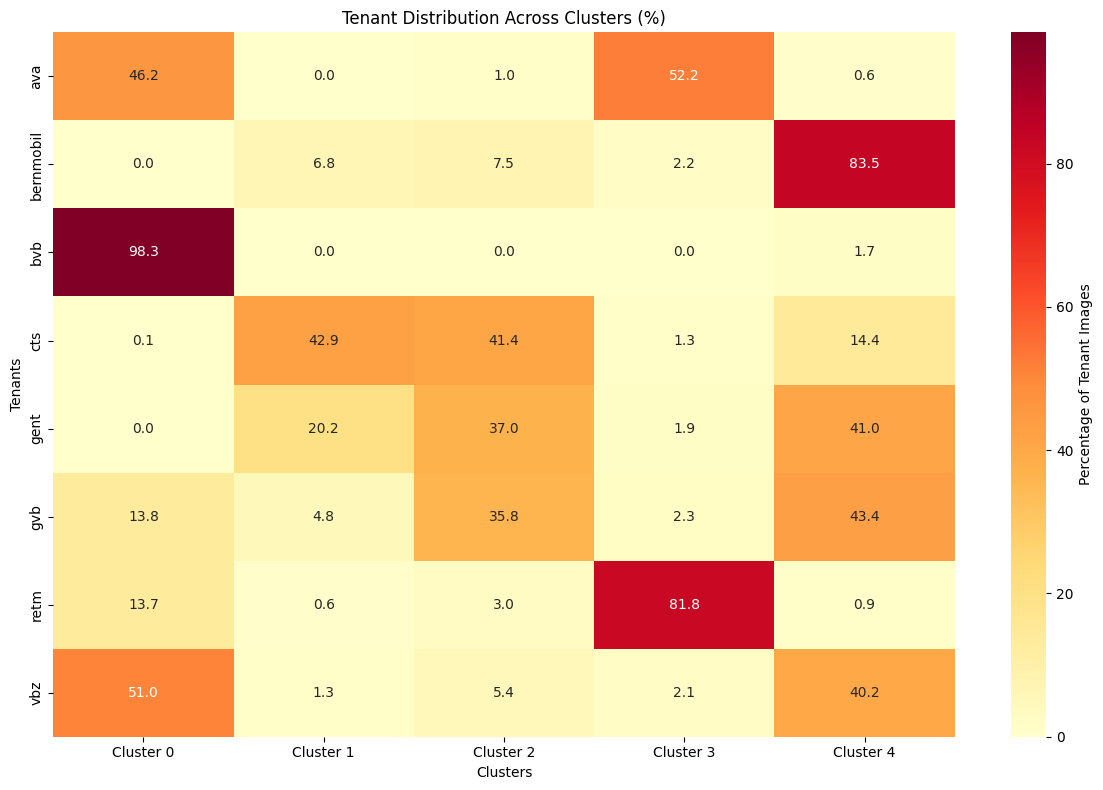


Detailed Tenant-Cluster Distribution:

ava (1250 images):
  Cluster 0: 578 images (46.2%)
  Cluster 2: 12 images (1.0%)
  Cluster 3: 652 images (52.2%)
  Cluster 4: 8 images (0.6%)

bernmobil (1250 images):
  Cluster 1: 85 images (6.8%)
  Cluster 2: 94 images (7.5%)
  Cluster 3: 27 images (2.2%)
  Cluster 4: 1044 images (83.5%)

bvb (1250 images):
  Cluster 0: 1229 images (98.3%)
  Cluster 4: 21 images (1.7%)

cts (1250 images):
  Cluster 0: 1 images (0.1%)
  Cluster 1: 536 images (42.9%)
  Cluster 2: 517 images (41.4%)
  Cluster 3: 16 images (1.3%)
  Cluster 4: 180 images (14.4%)

gent (1250 images):
  Cluster 1: 252 images (20.2%)
  Cluster 2: 462 images (37.0%)
  Cluster 3: 24 images (1.9%)
  Cluster 4: 512 images (41.0%)

gvb (1250 images):
  Cluster 0: 172 images (13.8%)
  Cluster 1: 60 images (4.8%)
  Cluster 2: 447 images (35.8%)
  Cluster 3: 29 images (2.3%)
  Cluster 4: 542 images (43.4%)

retm (1250 images):
  Cluster 0: 171 images (13.7%)
  Cluster 1: 7 images (0.6%)
  Clus

In [44]:
# Analyze tenant distribution across clusters
print("=" * 80)
print("TENANT DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create tenant-cluster matrix
tenant_cluster_matrix = defaultdict(lambda: defaultdict(int))
total_by_tenant = defaultdict(int)

for img_file in image_files:
    tenant = img_file['tenant']
    cluster = img_file['cluster']
    tenant_cluster_matrix[tenant][cluster] += 1
    total_by_tenant[tenant] += 1

# Convert to DataFrame for easier visualization
tenants = sorted(total_by_tenant.keys())
clusters = sorted(set(cluster_labels))

matrix_data = []
for tenant in tenants:
    row = []
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        row.append(percentage)
    matrix_data.append(row)

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap_data = np.array(matrix_data)
sns.heatmap(
    heatmap_data,
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=tenants,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage of Tenant Images'}
)
plt.title('Tenant Distribution Across Clusters (%)')
plt.xlabel('Clusters')
plt.ylabel('Tenants')
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/tenant_cluster_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\nDetailed Tenant-Cluster Distribution:")
for tenant in tenants:
    print(f"\n{tenant} ({total_by_tenant[tenant]} images):")
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        if count > 0:
            print(f"  Cluster {cluster}: {count} images ({percentage:.1f}%)")

### 11. Clustering-Report (JSON) erstellen & Kernergebnisse ausgeben
**Was:**  
- erstellt `clustering_report.json` mit Zeitstempel-Informationen, Run-Metadaten und vollständigen K-Means-Ergebnissen
- Sammelt Dataset-Info (Bildanzahl, Feature-Dimension, PCA-Varianz) und K-Means-Resultate (k, Silhouette-Score, Inertia, Cluster-Größen)
- Integriert Tenant-Cluster-Analyse mit detaillierter Verteilungsmatrix pro Tenant über alle Cluster
 
**Warum:**  
- Alle Parameter, Metriken und Ergebnisse werden zentral für Nachvollziehbarkeit und Vergleichbarkeit archiviert
- Run-spezifische Metadaten ermöglichen systematische Analyse von Clustering-Stabilität über mehrere Läufe
- Fokus auf K-Means als finale, produktive Clustering-Methode
- Geschäftsspezifische Analyse zeigt, ob Clustering domänenrelevante Muster (Verkehrsunternehmen) erfasst
 
**Outputs:**  
- JSON-Report `clustering_report.json` in `RESULTS_PATH` mit vollständiger Run-Dokumentation und K-Means-Parametern
- Kompakte Übersicht mit Timestamp, optimalen K-Means-Parametern, Cluster-Größen und PCA-Varianz in der Ausgabe
- Absolute Pfade zu Analysis- und Cluster-Verzeichnissen für einfache Navigation

In [45]:
# Generate comprehensive clustering report with timestamp info (FINAL)

print("=" * 80)
print("TIMESTAMPED CLUSTERING ANALYSIS SUMMARY")
print("=" * 80)

# Fallback: compute silhouette scores here if not already available
try:
    kmeans_silhouette
except NameError:
    kmeans_silhouette = silhouette_score(features_pca, cluster_labels)

# Use existing tenant_distribution if it already exists; otherwise compute it
try:
    tenant_distribution
except NameError:
    tenant_distribution = dict(Counter(img['tenant'] for img in image_files))

# Build tenant-cluster analysis from image_files (independent of previous cells)
tenant_cluster_matrix_report = defaultdict(lambda: defaultdict(int))
total_by_tenant_report = Counter()
for img in image_files:
    tenant = img['tenant']
    cl = int(img['cluster'])
    tenant_cluster_matrix_report[tenant][cl] += 1
    total_by_tenant_report[tenant] += 1
tenants_report = sorted(total_by_tenant_report.keys())

clustering_report = {
    "run_info": {
        "timestamp": TIMESTAMP,
        "run_date": time.strftime("%Y-%m-%d %H:%M:%S"),
        "analysis_results_path": str(Path(RESULTS_PATH).resolve()),
        "clustered_images_path": str(Path(CLUSTERS_PATH).resolve())
    },
    "dataset_info": {
        "total_images": int(len(image_files)),
        "feature_dimension": int(FEATURE_DIM),
        "pca_components": int(PCA_COMPONENTS),
        "pca_explained_variance": float(pca.explained_variance_ratio_.sum()),
        "tenant_distribution": {k: int(v) for k, v in tenant_distribution.items()}
    },
    "kmeans_results": {
        "k": int(BEST_K),
        "silhouette_score": float(kmeans_silhouette),
        "inertia": float(kmeans_inertia),
        "cluster_sizes": {int(k): int(v) for k, v in Counter(int(l) for l in cluster_labels).items()}
    },
    "tenant_cluster_analysis": {
        tenant: {
            "total_images": int(total_by_tenant_report[tenant]),
            "cluster_distribution": {int(k): int(v) for k, v in tenant_cluster_matrix_report[tenant].items()}
        } for tenant in tenants_report
    }
}

# Save results to timestamped directory
with open(f"{RESULTS_PATH}/clustering_report.json", 'w') as f:
    json.dump(clustering_report, f, indent=2)

# Print summary
print(f"Analysis completed successfully!")
print(f"\nRun Information:")
print(f"- Timestamp: {TIMESTAMP}")
print(f"- Analysis results saved to: {RESULTS_PATH}")
print(f"- Clustered images saved to: {CLUSTERS_PATH}")

print(f"\nKey Findings:")
print(f"- Optimal number of clusters (K-Means): {BEST_K}")
print(f"- Best silhouette score: {kmeans_silhouette:.4f}")
print(f"- PCA captured {pca.explained_variance_ratio_.sum():.1%} of the variance")

print(f"\nCluster sizes (K-Means):")
cluster_sizes = Counter(cluster_labels)
for cluster_id, size in sorted(cluster_sizes.items()):
    percentage = (size / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {size} images ({percentage:.1f}%)")

print(f"\n✓ Final clustering report saved to: {RESULTS_PATH}/clustering_report.json")

TIMESTAMPED CLUSTERING ANALYSIS SUMMARY
Analysis completed successfully!

Run Information:
- Timestamp: 20250907_151404
- Analysis results saved to: ./results_20250907_151404/clustering_analysis
- Clustered images saved to: ./results_20250907_151404/clustered_images

Key Findings:
- Optimal number of clusters (K-Means): 5
- Best silhouette score: 0.4007
- PCA captured 95.3% of the variance

Cluster sizes (K-Means):
  Cluster 0: 2789 images (27.9%)
  Cluster 1: 956 images (9.6%)
  Cluster 2: 1637 images (16.4%)
  Cluster 3: 1797 images (18.0%)
  Cluster 4: 2821 images (28.2%)

✓ Final clustering report saved to: ./results_20250907_151404/clustering_analysis/clustering_report.json


## 12. Ergebnisse der Clustering Phase
 
- Das dichtebasierte Cluster mit DBSCAN konnte keinen zuverlässigen Erfolg liefern, trotz vielfacher Anpassung der Parameter.
- Die Ergebnisse über die K-Means-Methode waren zufriedenstellend.
- Die Ergebnisse der Cluster wurden mit drei unterschiedlichen Metriken bewertet. Neben den gezeigten Metriken wurden in einer separaten Analyse weitere Cluster-Gütemaße evaluiert, diese Ergebnisse sind in diesem Notebook noch nicht enthalten. Konkret kamen der Silhouette Score, der Davies–Bouldin Index und der Calinski–Harabasz Index zum Einsatz. Für Hintergrund und einen vergleichenden Überblick siehe: Arbelaitz et al. (2013).
- Es wurde versucht mit Hilfe von einer Bildvorverarbeitung die Bilder vorzuverarbeiten, um z.B. dunkle Bilder aufzuhellen. Dies wurde im Schritt 5.1 optional in diesem Notebook eingebaut. Es konnte allerdings kein nennenswerter Effekt bzw. Verschlechterungen festgestellt werden, weshalb wir uns im folgenden dazu entschieden haben keine Bildvorverarbeitung vorzunehmen.
- Zusätzlich wurden folgende Konfigurationen getestet. Die Experimente wurden mit Hilfe des Python-Files `kmeans_experiments.py`
    - Feature-Extraction-Model: ResNet50,VGG16
    - je Modell verschiedene Layer im Model:
    `
    'levels': {
            'top': {'pooling': 'avg', 'layer': None},
            'mid': {'layer': 'conv4_block6_out'/'block4_conv3'}
            'low': {'layer': 'conv3_block4_out'/'block2_conv2'}
        }
    ` 
- Als beste Konfiguration hat sich das ResNet50 mit conv4_block6_out als Layer und keiner Bildvorverarbeitung herausgestellt.
    - Die Ergebnisse aller Experimente sind in der mitgeschickten results.json.
- Es wurden zwei Clustering Läufe mit jeweils 10.000 Bildern initialisiert (also insgesamt 20.000 unterschiedlichen Bildern). Ein Test mit 50.000 Bildern führte zu nicht plausiblen Clustern mit K-Means und wurde deshalb verworfen. Eine Analyse, weshalb der Lauf mit 50.000 Bildern nicht funktionierte wurde nicht angestrebt, da ein Clustering mit 20.000 Bildern für unsere Zwecke vollkommen ausreichend ist.
- Die entstandenen 5 Cluster wurden anschließend manuell gesichtet und bereinigt. Es wurden folgende fünf Klassen identifiziert:
    - Beton/Asphalt
    - Gras/natürliche Untergründe (z.B. auch Laub)
    - Schotter
    - Stein (verschiedene Pflaster-Arten)
    - Messfehler (zu dunkle Bilder, verrauschte Bilder)
- Während der Bereinigung wurden fehlerhaft zugeordnete Bilder manuell entfernt, bevor ein Training des Klassifizierungsmodell stattfindet. Die entfernten Bilder wurden gesammelt und können somit später als Spezialfälle gesondert analysiert werden.
- Das Ziel durch das Clustering die Daten zu sortieren und für das Labeling vorzubereiten konnte dadurch erreicht werden.